

 # **Imports and Setup**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc)
import os
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment setup complete")

Environment setup complete


# **Load MIMII Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Base directory for all pump data
BASE_PATH = "/content/drive/My Drive/TractorCare/data/pump/"

# Machine IDs
machine_ids = ["id_00", "id_02", "id_04", "id_06"]

normal_files = []
abnormal_files = []

# Loop through each machine ID and collect .wav files
for mid in machine_ids:
    normal_dir = os.path.join(BASE_PATH, mid, "normal")
    abnormal_dir = os.path.join(BASE_PATH, mid, "abnormal")

    # Check existence before listing
    if os.path.exists(normal_dir):
        normal_files.extend(
            [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith('.wav')]
        )
    if os.path.exists(abnormal_dir):
        abnormal_files.extend(
            [os.path.join(abnormal_dir, f) for f in os.listdir(abnormal_dir) if f.endswith('.wav')]
        )

print(f"Normal samples found: {len(normal_files)}")
print(f"Abnormal samples found: {len(abnormal_files)}")

Mounted at /content/drive
Normal samples found: 2845
Abnormal samples found: 456


## **Handling Multiple Data Sources & Future Data**

While this notebook currently utilizes the MIMII Dataset for pump sounds, the approach is designed to be adaptable for integrating data from multiple sources, such as the upcoming tractor sound dataset.

When incorporating new audio data sources or additional data over time, the following strategy will be employed:

1.  **Consistent Feature Extraction:** The `extract_mfcc_features` function, or a similar standardized feature extraction pipeline, will be applied uniformly to all audio files from every source. This ensures that the extracted features have consistent dimensions and meaning across the entire dataset.
2.  **Data Merging/Concatenation:** The extracted feature arrays from different sources will be combined into a single, unified dataset. This typically involves concatenating the feature arrays (e.g., using `numpy.vstack` or similar) and creating corresponding labels that identify the source and condition (normal/abnormal).
3.  **Handling Data Duplication:** Before merging, steps will be taken to identify and handle potential data duplication if the new dataset overlaps with existing data. This might involve checking file metadata, timestamps, or even comparing feature vectors for near-duplicates.
4.  **Re-balancing (if necessary):** After merging, the class distribution (normal vs. abnormal) will be re-evaluated. If the combined dataset is imbalanced, resampling techniques (like the undersampling used previously, or oversampling) will be applied again to ensure a balanced dataset for model training.
5.  **Source as a Feature (Optional):** In some cases, the data source itself could be treated as an additional feature or used in a multi-task learning setup if there are distinct characteristics between sources.

This modular approach ensures that the machine learning models can be trained on a comprehensive dataset, regardless of the number or origin of the audio sources, while maintaining data integrity and handling potential issues like imbalance and duplication.

# **Data Visualization - Waveforms**
Show how loud the sound is changing over time.

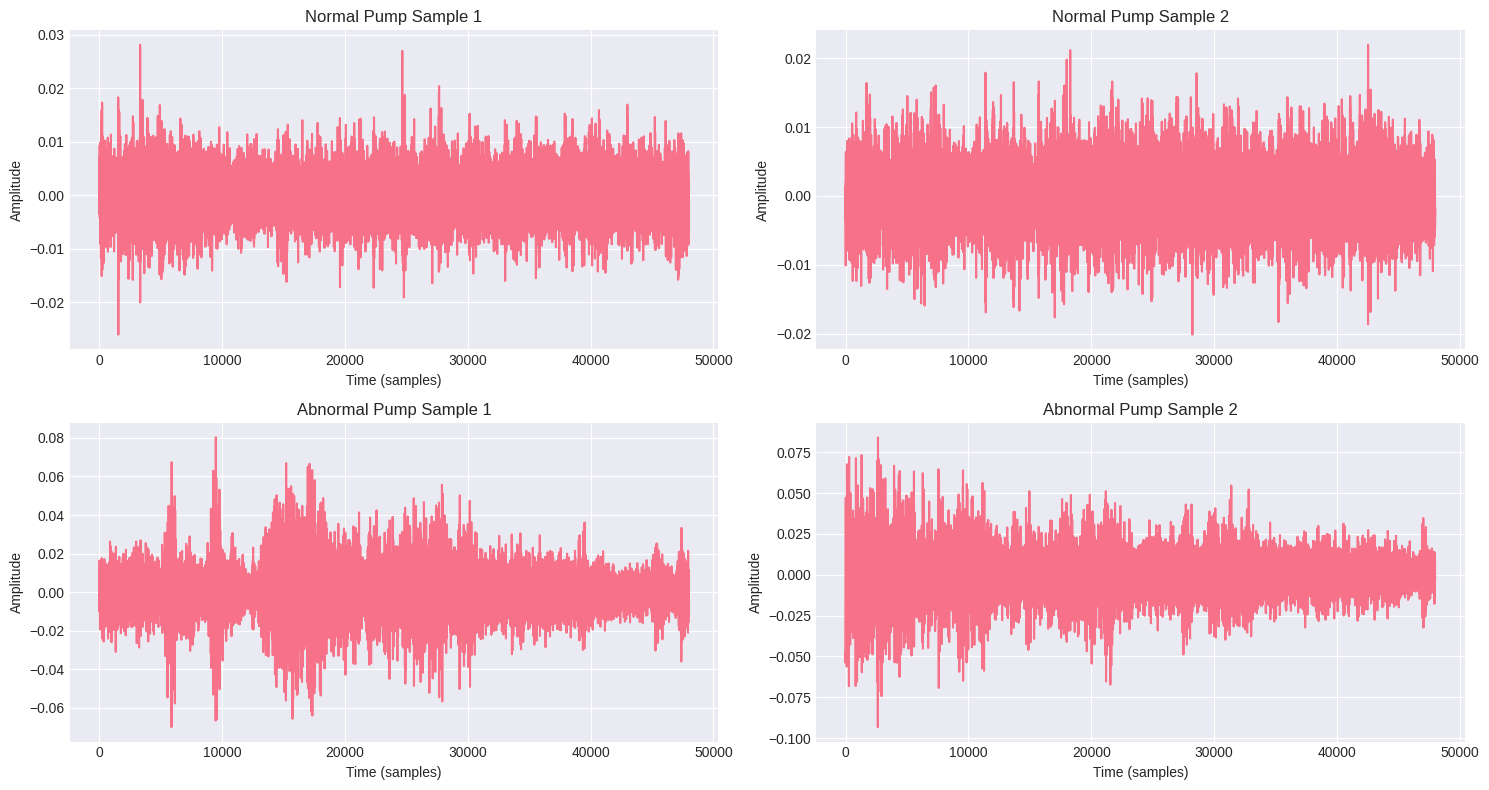

In [3]:
# Visualize sample waveforms (use first 2 from each class)
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Normal samples
for i in range(2):
    audio, sr = librosa.load(normal_files[i], sr=16000, duration=3)
    axes[0, i].plot(audio)
    axes[0, i].set_title(f'Normal Pump Sample {i+1}')
    axes[0, i].set_xlabel('Time (samples)')
    axes[0, i].set_ylabel('Amplitude')

# Abnormal samples
for i in range(2):
    audio, sr = librosa.load(abnormal_files[i], sr=16000, duration=3)
    axes[1, i].plot(audio)
    axes[1, i].set_title(f'Abnormal Pump Sample {i+1}')
    axes[1, i].set_xlabel('Time (samples)')
    axes[1, i].set_ylabel('Amplitude')

plt.tight_layout()
plt.savefig('waveforms_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# **Spectrograms**
Show which frequencies are present in the sound and how their loudness changes over time. Useful for seeing patterns.

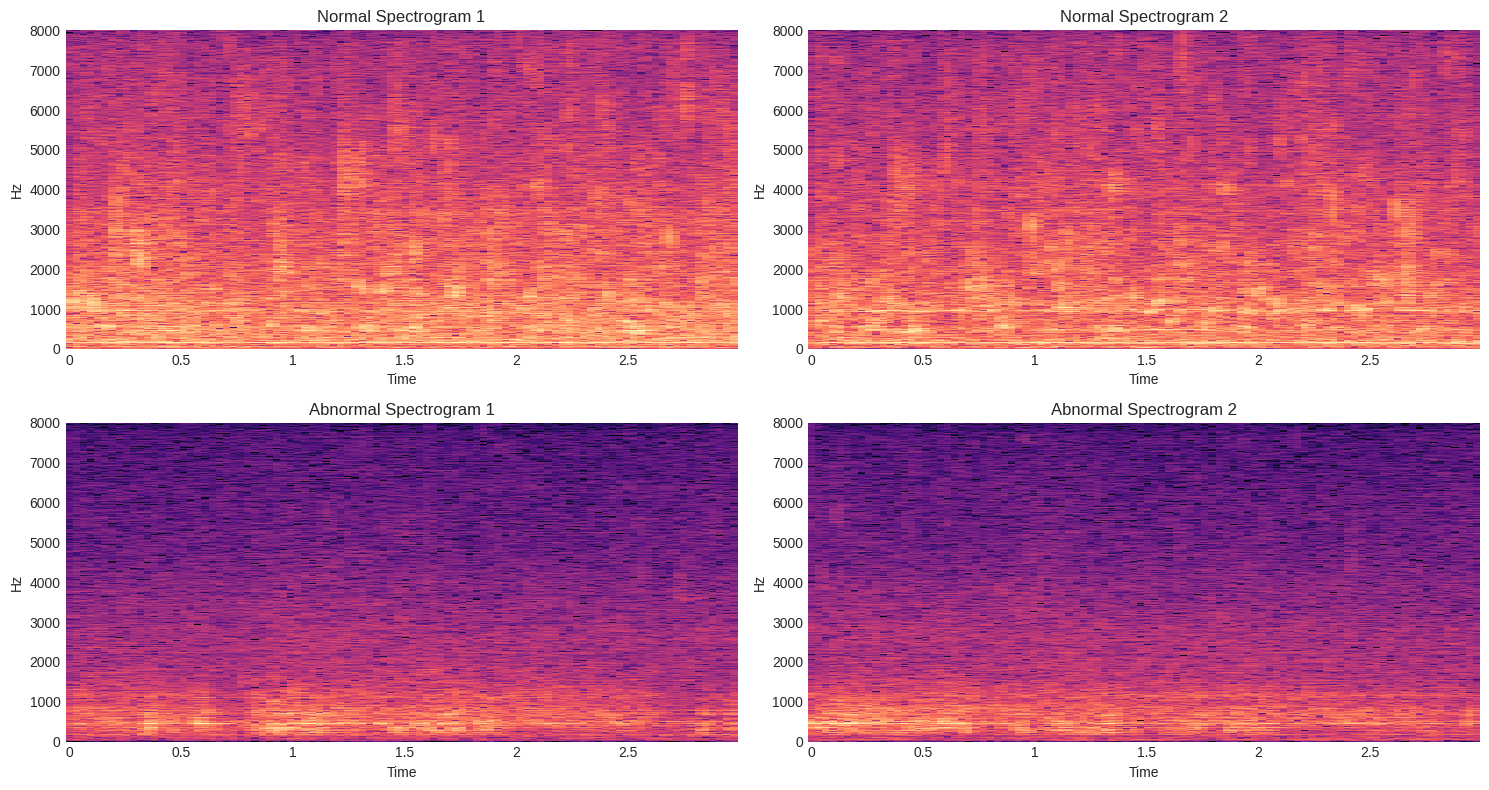

In [4]:
# Visualize spectrograms
fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Normal
for i in range(2):
    audio, sr = librosa.load(normal_files[i], sr=16000, duration=3)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[0, i])
    axes[0, i].set_title(f'Normal Spectrogram {i+1}')

# Abnormal
for i in range(2):
    audio, sr = librosa.load(abnormal_files[i], sr=16000, duration=3)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', ax=axes[1, i])
    axes[1, i].set_title(f'Abnormal Spectrogram {i+1}')

plt.tight_layout()
plt.savefig('spectrograms_comparison.png', dpi=300)
plt.show()

# **Noise Reduction Considerations**

Noise in real-world audio can hinder anomaly detection by masking true anomalies or creating false ones. Applying noise reduction is crucial, especially with new, potentially noisy data. Techniques include:

1.  **Spectral Gating:** Suppressing frequencies below a certain loudness threshold.
2.  **Noise Profiling:** Subtracting a recorded noise sample from the audio.
3.  **Deep Learning-based Denoising:** Using neural networks trained to remove noise.

Incorporating filtering (like high-pass or low-pass) or other techniques can be beneficial for noisy data like tractor sounds.

# **Feature Extraction explanation**

Mel-Frequency Cepstral Coefficients (MFCCs) are widely used features in audio processing, particularly for tasks like speech recognition and music genre classification. They effectively capture the spectral envelope of a sound, which is crucial for distinguishing different audio events or sources. This makes them suitable for identifying distinct patterns between 'normal' and 'abnormal' pump sounds.

The `extract_mfcc_features` function includes a `max_len` parameter. This parameter is used to ensure that all extracted MFCC feature arrays have a fixed size. This process provides a uniform input size for the models, allowing them to process the data effectively.


In [19]:
def extract_mfcc_features(file_path, n_mfcc=40, max_len=100):
    """
    Extract MFCC features from audio file with an optional high-pass filter.

    Parameters:
    - file_path: Path to the audio file.
    - n_mfcc: Number of MFCC coefficients to extract.
    - max_len: Maximum length of the MFCC sequence.

    Returns:
    - mfcc: numpy array of shape (n_mfcc, max_len) or None if processing fails.
    """
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=16000, duration=10)

        # Apply a simple high-pass filter (e.g., cutoff at 100 Hz)
        # This is a basic implementation, more sophisticated filters might be needed.
        from scipy.signal import butter, filtfilt
        nyquist = 0.5 * sr
        cutoff = 100  # Hz
        normal_cutoff = cutoff / nyquist
        # Get the filter coefficients
        b, a = butter(5, normal_cutoff, btype='high', analog=False)
        # Apply the filter
        audio = filtfilt(b, a, audio)


        # Extract MFCCs
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

        # Pad or truncate to fixed length
        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]

        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extract features for visualization samples only
print("Extracting MFCC features for visualization...")
X_normal_sample = []
X_abnormal_sample = []

for file in normal_files[:5]:  # Just for visualization
    mfcc = extract_mfcc_features(file)
    if mfcc is not None:
        X_normal_sample.append(mfcc)

for file in abnormal_files[:5]:
    mfcc = extract_mfcc_features(file)
    if mfcc is not None:
        X_abnormal_sample.append(mfcc)

print(f" Extracted {len(X_normal_sample)} normal and {len(X_abnormal_sample)} abnormal samples for visualization")

Extracting MFCC features for visualization...
 Extracted 5 normal and 5 abnormal samples for visualization


# **Visualize MFCC Features**

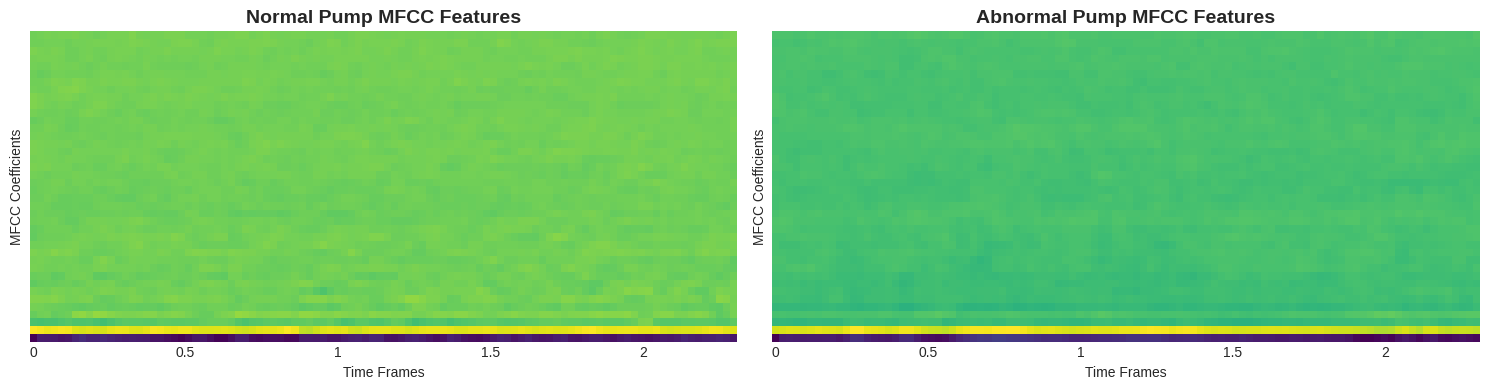

In [6]:
# Show sample MFCC
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

librosa.display.specshow(X_normal_sample[0], x_axis='time', ax=axes[0], cmap='viridis')
axes[0].set_title('Normal Pump MFCC Features', fontsize=14, fontweight='bold')
axes[0].set_ylabel('MFCC Coefficients')
axes[0].set_xlabel('Time Frames')

librosa.display.specshow(X_abnormal_sample[0], x_axis='time', ax=axes[1], cmap='viridis')
axes[1].set_title('Abnormal Pump MFCC Features', fontsize=14, fontweight='bold')
axes[1].set_ylabel('MFCC Coefficients')
axes[1].set_xlabel('Time Frames')

plt.tight_layout()
plt.savefig('mfcc_comparison.png', dpi=300)
plt.show()



# **Handle Class Imbalance + Extract Features from ALL files**

In [8]:
from sklearn.utils import resample
from tqdm.notebook import tqdm

# Balance the dataset
# Option 1: Undersample normal to match abnormal
normal_sample_size = len(abnormal_files)  # 456
normal_files_balanced = resample(normal_files,
                                 n_samples=normal_sample_size,
                                 random_state=42)

print(f"Balanced dataset:")
print(f"  Normal: {len(normal_files_balanced)}")
print(f"  Abnormal: {len(abnormal_files)}")

def extract_mfcc_features(file_path, n_mfcc=40, max_len=100):
    """Extract MFCC features from audio file"""
    try:
        audio, sr = librosa.load(file_path, sr=16000, duration=10)
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

        if mfcc.shape[1] < max_len:
            pad_width = max_len - mfcc.shape[1]
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_len]

        return mfcc
    except Exception as e:
        return None

# Extract features from BALANCED dataset
print("\nExtracting MFCC features from all balanced samples...")
X_normal = []
X_abnormal = []

# Use all abnormal (456) and balanced normal (456)
print("\nProcessing normal samples...")
for file in tqdm(normal_files_balanced, desc="Normal"):
    mfcc = extract_mfcc_features(file)
    if mfcc is not None:
        X_normal.append(mfcc)

print("\nProcessing abnormal samples...")
for file in tqdm(abnormal_files, desc="Abnormal"):
    mfcc = extract_mfcc_features(file)
    if mfcc is not None:
        X_abnormal.append(mfcc)

print(f"\n Feature extraction complete!")
print(f"  Normal samples: {len(X_normal)}")
print(f"  Abnormal samples: {len(X_abnormal)}")
print(f"  Total dataset size: {len(X_normal) + len(X_abnormal)}")

Balanced dataset:
  Normal: 456
  Abnormal: 456

Extracting MFCC features from all balanced samples...

Processing normal samples...


Normal:   0%|          | 0/456 [00:00<?, ?it/s]


Processing abnormal samples...


Abnormal:   0%|          | 0/456 [00:00<?, ?it/s]


 Feature extraction complete!
  Normal samples: 456
  Abnormal samples: 456
  Total dataset size: 912


# **Noise Reduction Considerations**

Real-world audio data is often contaminated with various types of noise, such as background machinery sounds, environmental noise, or electrical interference. For anomaly detection tasks like identifying abnormal pump sounds, the presence of significant noise can make it challenging for models to distinguish between genuine anomalies and noisy normal samples. Noise can mask subtle acoustic cues that characterize an anomaly or introduce spurious patterns that the model might incorrectly interpret as abnormal. Therefore, applying noise reduction techniques can be a crucial preprocessing step, especially when dealing with a new dataset where the noise characteristics might differ from the training data.

Several techniques can be employed for noise reduction in audio:

1.  **Spectral Gating:** This method works by identifying frequency components that are significantly louder than the surrounding noise in the frequency domain. It then "gates" or reduces the amplitude of frequencies that are below a certain threshold, effectively suppressing background noise while preserving the dominant signal.
2.  **Noise Profiling:** This involves capturing a sample of the background noise when the target sound (e.g., the pump) is not present. This noise profile is then subtracted from the entire audio signal to remove the estimated noise components. This is effective when the noise is relatively stationary.
3.  **Deep Learning-based Denoising:** More advanced techniques utilize neural networks trained on large datasets of noisy and clean audio to learn how to remove noise. Autoencoders or U-Net architectures are commonly used for this purpose. These methods can be powerful for complex and non-stationary noise but require significant data and computational resources for training.


In [ ]:
# Placeholder for Noise Reduction Implementation
print("Placeholder for noise reduction implementation added.")

# **Feature aggregation for traditional models**
##**Prepare Data for Traditional ML**

For traditional machine learning algorithms like K-Nearest Neighbors, and Support Vector Machines, the input data typically needs to be in a fixed-size vector format. Unlike some deep learning architectures that can directly process sequential or multi-dimensional data (like the CNN using the 2D MFCC arrays), these models require a consistent number of features for each sample.

The extracted MFCC features for each audio file have a shape of `(n_mfcc, max_len)`, which is a 2D array. Although we padded or truncated to a `max_len`, the time dimension (the second dimension) still varies slightly depending on the exact length of the audio after loading, or more importantly, traditional models cannot directly handle this 2D grid structure as input.

To convert these 2D MFCC arrays into a fixed-size 1D vector suitable for traditional ML, we compute statistics across the time dimension (`axis=1`). The mean and standard deviation are commonly used statistical measures for this purpose.

-   The **mean** of each MFCC coefficient across all time frames captures the average spectral characteristic over the duration of the audio segment.
-   The **standard deviation** of each MFCC coefficient across all time frames captures the variability or temporal dynamics of that spectral characteristic.



In [9]:
# For traditional ML (not deep learning), compute statistics
def compute_statistics(mfcc):
    """Compute mean and std of MFCC coefficients"""
    return np.concatenate([np.mean(mfcc, axis=1), np.std(mfcc, axis=1)])

X_normal_stats = np.array([compute_statistics(x) for x in X_normal])
X_abnormal_stats = np.array([compute_statistics(x) for x in X_abnormal])

# Combine and create labels
X_traditional = np.vstack([X_normal_stats, X_abnormal_stats])
y_traditional = np.concatenate([np.zeros(len(X_normal_stats)),
                                np.ones(len(X_abnormal_stats))])

# Split data
X_train_trad, X_test_trad, y_train_trad, y_test_trad = train_test_split(
    X_traditional, y_traditional, test_size=0.2, random_state=42
)

# Scale features
scaler = StandardScaler()
X_train_trad = scaler.fit_transform(X_train_trad)
X_test_trad = scaler.transform(X_test_trad)

print(f"Training set (Traditional ML): {X_train_trad.shape}")
print(f"Test set (Traditional ML): {X_test_trad.shape}")


# Algorithm 1: K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

print("\nTraining KNN...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_trad, y_train_trad)
knn_pred = knn_model.predict(X_test_trad)

knn_results = {
    'accuracy': accuracy_score(y_test_trad, knn_pred),
    'precision': precision_score(y_test_trad, knn_pred),
    'recall': recall_score(y_test_trad, knn_pred),
    'f1': f1_score(y_test_trad, knn_pred)
}
print(" KNN trained")
print(knn_results)

# Algorithm 2: Isolation Forest (Unsupervised Anomaly Detection)
from sklearn.ensemble import IsolationForest

print("\nTraining Isolation Forest...")
iso_model = IsolationForest(contamination=0.5, random_state=42)
iso_model.fit(X_train_trad)
iso_pred = iso_model.predict(X_test_trad)
# Convert to binary (1=normal, -1=anomaly -> 0=normal, 1=anomaly)
iso_pred = np.where(iso_pred == 1, 0, 1)

iso_results = {
    'accuracy': accuracy_score(y_test_trad, iso_pred),
    'precision': precision_score(y_test_trad, iso_pred),
    'recall': recall_score(y_test_trad, iso_pred),
    'f1': f1_score(y_test_trad, iso_pred)
}
print(" Isolation Forest trained")
print(iso_results)


# Algorithm 3: Support Vector Machine
from sklearn.svm import SVC

print("\nTraining SVM...")
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_trad, y_train_trad)
svm_pred = svm_model.predict(X_test_trad)

svm_results = {
    'accuracy': accuracy_score(y_test_trad, svm_pred),
    'precision': precision_score(y_test_trad, svm_pred),
    'recall': recall_score(y_test_trad, svm_pred),
    'f1': f1_score(y_test_trad, svm_pred)
}
print(" SVM trained")
print(svm_results)

Training set (Traditional ML): (729, 80)
Test set (Traditional ML): (183, 80)

Training KNN...
 KNN trained
{'accuracy': 0.9726775956284153, 'precision': 1.0, 'recall': 0.9468085106382979, 'f1': 0.9726775956284153}

Training Isolation Forest...
 Isolation Forest trained
{'accuracy': 0.4808743169398907, 'precision': 0.4948453608247423, 'recall': 0.5106382978723404, 'f1': 0.5026178010471204}

Training SVM...
 SVM trained
{'accuracy': 0.9672131147540983, 'precision': 0.9782608695652174, 'recall': 0.9574468085106383, 'f1': 0.967741935483871}


In [10]:
# For CNN, 2D structure
X_cnn = np.array(X_normal + X_abnormal)
y_cnn = np.concatenate([np.zeros(len(X_normal)), np.ones(len(X_abnormal))])

# Split
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn, y_cnn, test_size=0.2, random_state=42
)

# Reshape for CNN (samples, height, width, channels)
X_train_cnn = X_train_cnn[..., np.newaxis]
X_test_cnn = X_test_cnn[..., np.newaxis]

print(f"CNN Training set: {X_train_cnn.shape}")
print(f"CNN Test set: {X_test_cnn.shape}")

# Algorithm 4: CNN (Deep Learning)
import tensorflow as tf
from tensorflow import keras

print("\nTraining CNN...")
cnn_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 100, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=20, validation_split=0.2, verbose=0)

cnn_pred_probs = cnn_model.predict(X_test_cnn)
cnn_pred = (cnn_pred_probs > 0.5).astype(int).flatten()

cnn_results = {
    'accuracy': accuracy_score(y_test_cnn, cnn_pred),
    'precision': precision_score(y_test_cnn, cnn_pred),
    'recall': recall_score(y_test_cnn, cnn_pred),
    'f1': f1_score(y_test_cnn, cnn_pred),
    'loss': history.history['loss'][-1]
}
print(" CNN trained")
print(cnn_results)


# Implement and train VGG-like model
print("\nTraining VGG-like CNN...")

# VGG-like architecture
vgg_model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(40, 100, 1)),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_vgg = vgg_model.fit(X_train_cnn, y_train_cnn, epochs=20, validation_split=0.2, verbose=0)

vgg_pred_probs = vgg_model.predict(X_test_cnn)
vgg_pred = (vgg_pred_probs > 0.5).astype(int).flatten()

vgg_results = {
    'accuracy': accuracy_score(y_test_cnn, vgg_pred),
    'precision': precision_score(y_test_cnn, vgg_pred),
    'recall': recall_score(y_test_cnn, vgg_pred),
    'f1': f1_score(y_test_cnn, vgg_pred),
    'loss': history_vgg.history['loss'][-1]
}
print(" VGG-like CNN trained")
print(vgg_results)

# Implement and train ResNet-like model
print("\nTraining ResNet-like CNN...")

def resnet_block(x, filters, kernel_size=3, stride=1):
    """A simplified ResNet block."""
    y = keras.layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    y = keras.layers.BatchNormalization()(y)
    y = keras.layers.Conv2D(filters, kernel_size, strides=1, padding='same')(y)
    y = keras.layers.BatchNormalization()(y)

    if stride != 1 or x.shape[-1] != filters:
        x = keras.layers.Conv2D(filters, 1, strides=stride, padding='same')(x)
        x = keras.layers.BatchNormalization()(x)

    out = keras.layers.Add()([x, y])
    out = keras.layers.ReLU()(out)
    return out

# ResNet-like architecture
input_shape = (40, 100, 1)
inputs = keras.Input(shape=input_shape)

x = keras.layers.Conv2D(32, 7, strides=2, padding='same', activation='relu')(inputs)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

x = resnet_block(x, 32)
x = resnet_block(x, 32)

x = resnet_block(x, 64, stride=2)
x = resnet_block(x, 64)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

resnet_model = keras.Model(inputs=inputs, outputs=outputs)

resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_resnet = resnet_model.fit(X_train_cnn, y_train_cnn, epochs=20, validation_split=0.2, verbose=0)

resnet_pred_probs = resnet_model.predict(X_test_cnn)
resnet_pred = (resnet_pred_probs > 0.5).astype(int).flatten()

resnet_results = {
    'accuracy': accuracy_score(y_test_cnn, resnet_pred),
    'precision': precision_score(y_test_cnn, resnet_pred),
    'recall': recall_score(y_test_cnn, resnet_pred),
    'f1': f1_score(y_test_cnn, resnet_pred),
    'loss': history_resnet.history['loss'][-1]
}
print(" ResNet-like CNN trained")
print(resnet_results)

CNN Training set: (729, 40, 100, 1)
CNN Test set: (183, 40, 100, 1)

Training CNN...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
 CNN trained
{'accuracy': 0.9398907103825137, 'precision': 0.9191919191919192, 'recall': 0.9680851063829787, 'f1': 0.9430051813471503, 'loss': 0.007104565389454365}

Training VGG-like CNN...
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
 VGG-like CNN trained
{'accuracy': 0.9726775956284153, 'precision': 0.968421052631579, 'recall': 0.9787234042553191, 'f1': 0.9735449735449735, 'loss': 0.037380024790763855}

Training ResNet-like CNN...


6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 258ms/step
 ResNet-like CNN trained
{'accuracy': 0.9726775956284153, 'precision': 0.9587628865979382, 'recall': 0.9893617021276596, 'f1': 0.9738219895287958, 'loss': 0.026399655267596245}


# **Results Comparison Table**

In [14]:
# Create comparison table
results_df = pd.DataFrame({
    'Algorithm': ['KNN', 'Isolation Forest', 'SVM', 'CNN', 'VGG-like CNN', 'ResNet-like CNN'],
    'Accuracy': [knn_results['accuracy'],
                 iso_results['accuracy'], svm_results['accuracy'],
                 cnn_results['accuracy'], vgg_results['accuracy'], resnet_results['accuracy']],
    'Precision': [knn_results['precision'],
                  iso_results['precision'], svm_results['precision'],
                  cnn_results['precision'], vgg_results['precision'], resnet_results['precision']],
    'Recall': [knn_results['recall'],
               iso_results['recall'], svm_results['recall'],
               cnn_results['recall'], vgg_results['recall'], resnet_results['recall']],
    'F1-Score': [knn_results['f1'],
                 iso_results['f1'], svm_results['f1'],
                 cnn_results['f1'], vgg_results['f1'], resnet_results['f1']]
})

results_df = results_df.round(4)
print("\n" + "="*70)
print("PERFORMANCE COMPARISON ACROSS ALL ALGORITHMS")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Save table
results_df.to_csv('model_comparison_results.csv', index=False)


PERFORMANCE COMPARISON ACROSS ALL ALGORITHMS
       Algorithm  Accuracy  Precision  Recall  F1-Score
             KNN    0.9727     1.0000  0.9468    0.9727
Isolation Forest    0.4809     0.4948  0.5106    0.5026
             SVM    0.9672     0.9783  0.9574    0.9677
             CNN    0.9399     0.9192  0.9681    0.9430
    VGG-like CNN    0.9727     0.9684  0.9787    0.9735
 ResNet-like CNN    0.9727     0.9588  0.9894    0.9738


# **Visualize Results**

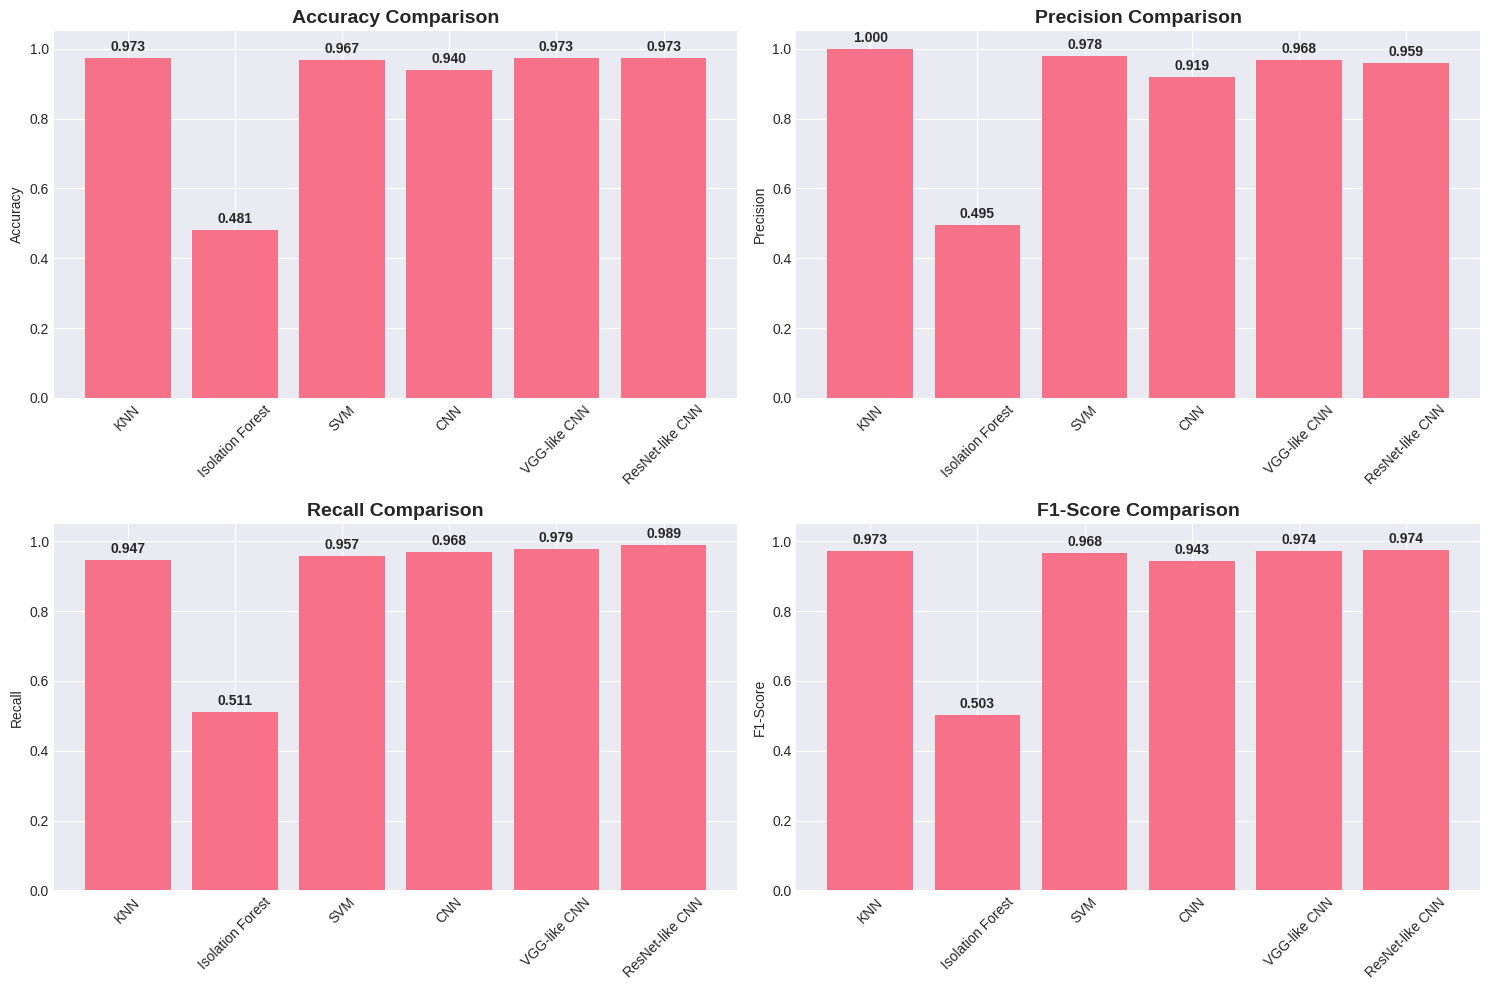

In [15]:
# Bar chart comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(results_df['Algorithm'], results_df[metric])
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1.05]) # Extend y-limit slightly for labels
    ax.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for i, v in enumerate(results_df[metric]):
        ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig('algorithm_comparison_updated.png', dpi=300)
plt.show()

# **Confusion Matrices**

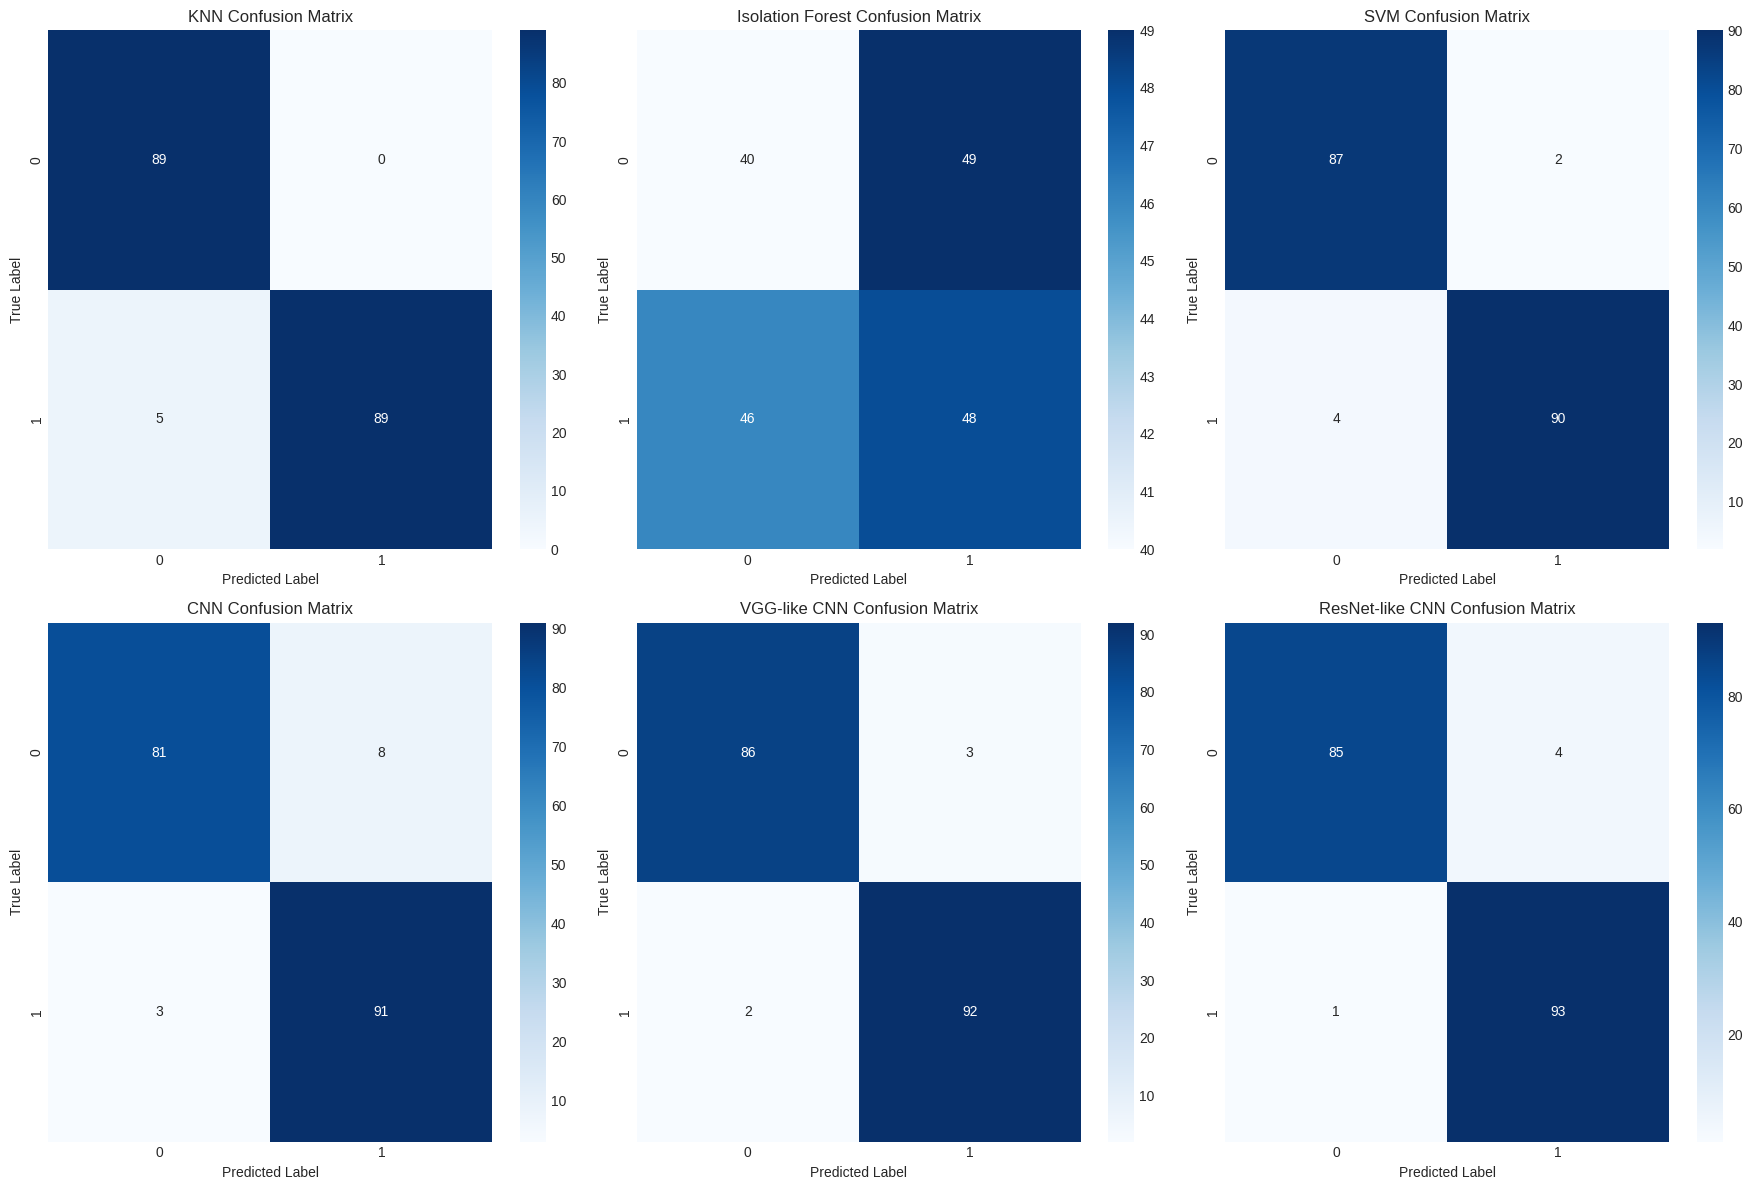

In [18]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

predictions = [knn_pred, iso_pred, svm_pred, cnn_pred, vgg_pred, resnet_pred]
names = [ 'KNN', 'Isolation Forest', 'SVM', 'CNN', 'VGG-like CNN', 'ResNet-like CNN']

for idx, (pred, name) in enumerate(zip(predictions, names)):
    ax = axes[idx // 3, idx % 3]
    # Use y_test_trad for the first 3 models, y_test_cnn for the last 3
    y_true = y_test_trad if idx < 3 else y_test_cnn
    cm = confusion_matrix(y_true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300)
plt.show()

# **Interpretation of Results**

Based on the performance metrics and confusion matrices, the supervised learning approaches (KNN, SVM, and the CNN variants) demonstrated superior performance in detecting abnormal pump sounds compared to the unsupervised Isolation Forest.

The traditional models (KNN, SVM) using statistical features and the deep learning models (VGG-like CNN, ResNet-like CNN) processing 2D MFCCs both achieved high performance. KNN had perfect precision, while VGG-like and ResNet-like CNNs showed strong recall.

Overall, KNN, SVM, VGG-like CNN, and ResNet-like CNN appear to be the most promising models for this task based on these initial results. Further analysis of the confusion matrices can reveal specific error types to inform model selection for deployment.